# Modelling Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\danie\Documents\GitHub\thesis\modelling


In [3]:
df = pd.read_csv('../Data/gold/covid_multivariate_w.csv')
df.head()

,date,country,new_cases,cases,co,no2,o3,pm10,pm25,so2,population
0,2020-01-20,Brazil,0,0,2.057143,5.461905,13.395238,13.490476,26.204762,1.452381,208126926
1,2020-01-27,Brazil,0,0,2.642857,6.876190,13.638095,15.890476,31.276190,5.347619,208126926
2,2020-02-03,Brazil,0,0,2.792857,6.109524,11.295238,12.714286,24.942857,3.633333,208126926
3,2020-02-10,Brazil,0,0,2.269048,5.914286,11.766667,13.033333,23.766667,3.257143,208126926
4,2020-02-17,Brazil,0,0,2.852381,6.657143,13.252381,14.419048,29.419048,3.076190,208126926


# Wrangle

In [4]:
df['cases_t_4'] = df.groupby('country')['new_cases'].shift(-4)
df['cases_t_1'] = df.groupby('country')['new_cases'].shift(-1)

In [6]:
df['cases_lag1'] = df.groupby('country')['cases'].shift(1)

In [7]:
print(df['cases_t_4'].isnull().sum(), 'Nans for cases_t_4')
print(df['cases_t_1'].isnull().sum(), 'Nans for cases_t_1')
print(df['cases_lag1'].isnull().sum(), 'Nans for cases_lag1')

28 Nans for cases_t_4
7 Nans for cases_t_1
7 Nans for cases_lag1


In [8]:
# drop if cases_t_4 is null
df = df.dropna(subset=['cases_t_4'])
df = df.dropna(subset=['cases_t_1'])
df = df.dropna(subset=['cases_lag1'])

In [9]:
# convert date to numeric
df['date'] = pd.to_datetime(df['date'])
df['date_numeric'] = df['date'].apply(lambda x: x.timestamp())

In [10]:
df_og = df.copy()

In [11]:
# dummies for countries
df = pd.get_dummies(df, columns=['country'], drop_first=True)

# Regression Framework

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def plot_country_residuals_scaled(df, model):
    countries = df['country'].unique()
    n_countries = len(countries)

    fig, axes = plt.subplots(nrows=2, ncols=(n_countries + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, country in enumerate(countries):
        # Filter data for the current country
        df_country = df[df['country'] == country]

        # Define explanatory and target variables
        y = df_country['new_cases']
        X = df_country.drop(columns=['cases','new_cases', 'cases_t_4','cases_t_1', 'date', 'country'])
        

        # Split data (80/20 split, time-series style)
        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        dates_test = df_country['date'].iloc[split_idx:]

        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit provided model on scaled data
        model.fit(X_train_scaled, y_train)

        # Predict and compute residuals
        y_pred = model.predict(X_test_scaled)
        residuals = y_test - y_pred

        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)

        # Plot residuals
        ax = axes[idx]
        ax.plot(dates_test, residuals, marker='o', linestyle='-', markersize=3)
        ax.axhline(y=0, color='red', linestyle='--')
        ax.set_title(f"{country} Residuals (MSE: {mse:.2f})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Residual")
        ax.tick_params(axis='x', rotation=45)

    # Remove any empty subplots
    for idx in range(n_countries, len(axes)):
        fig.delaxes(axes[idx])

    fig.tight_layout()
    plt.show()

# Example usage:
# from sklearn.linear_model import Lasso
# plot_country_residuals(df_og, Lasso(alpha=1.0))


# OLS

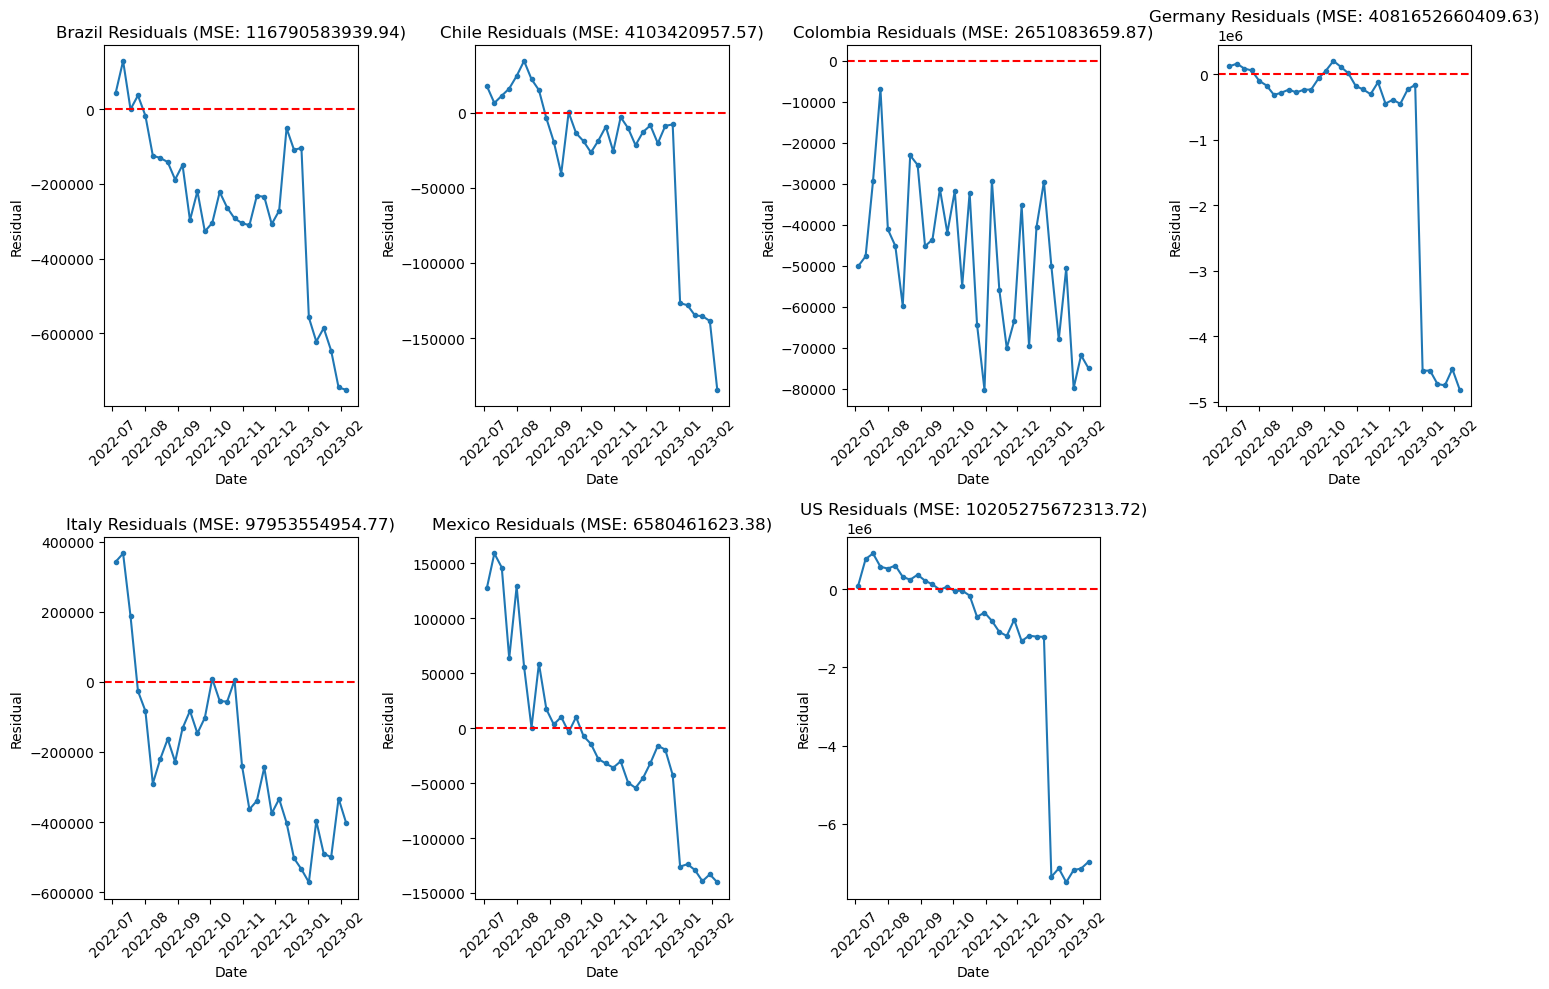

In [13]:
from sklearn.linear_model import LinearRegression
plot_country_residuals_scaled(df_og, LinearRegression())

## Lasso

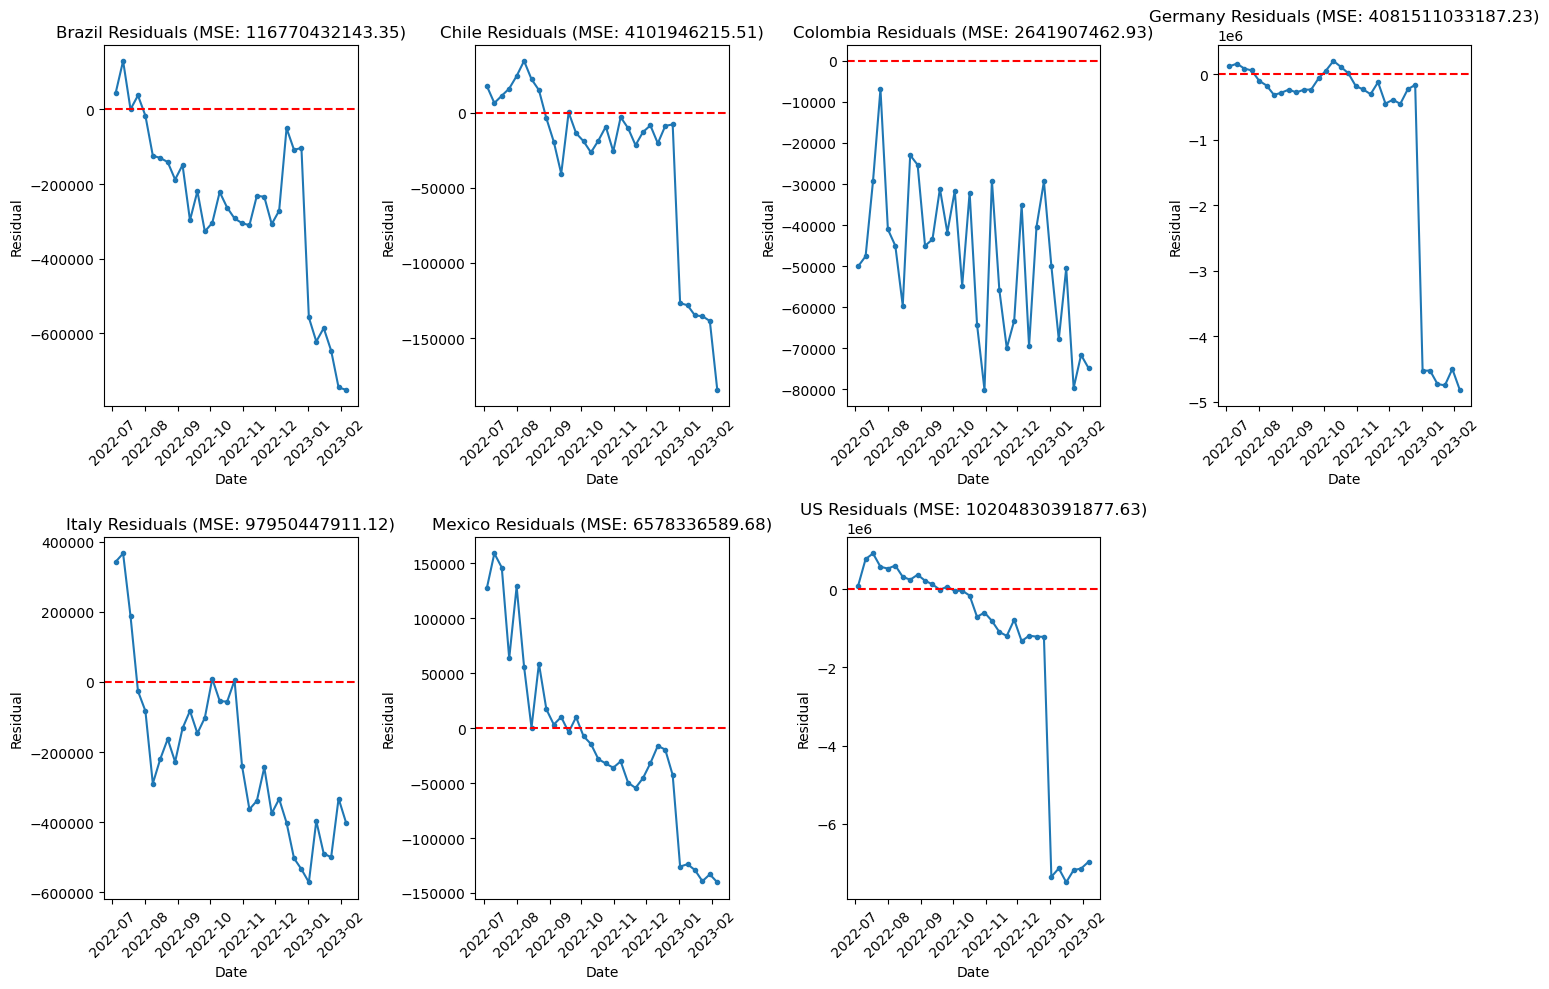

In [14]:
from sklearn.linear_model import Lasso
plot_country_residuals_scaled(df_og, Lasso(alpha=1.0))

## Ridge

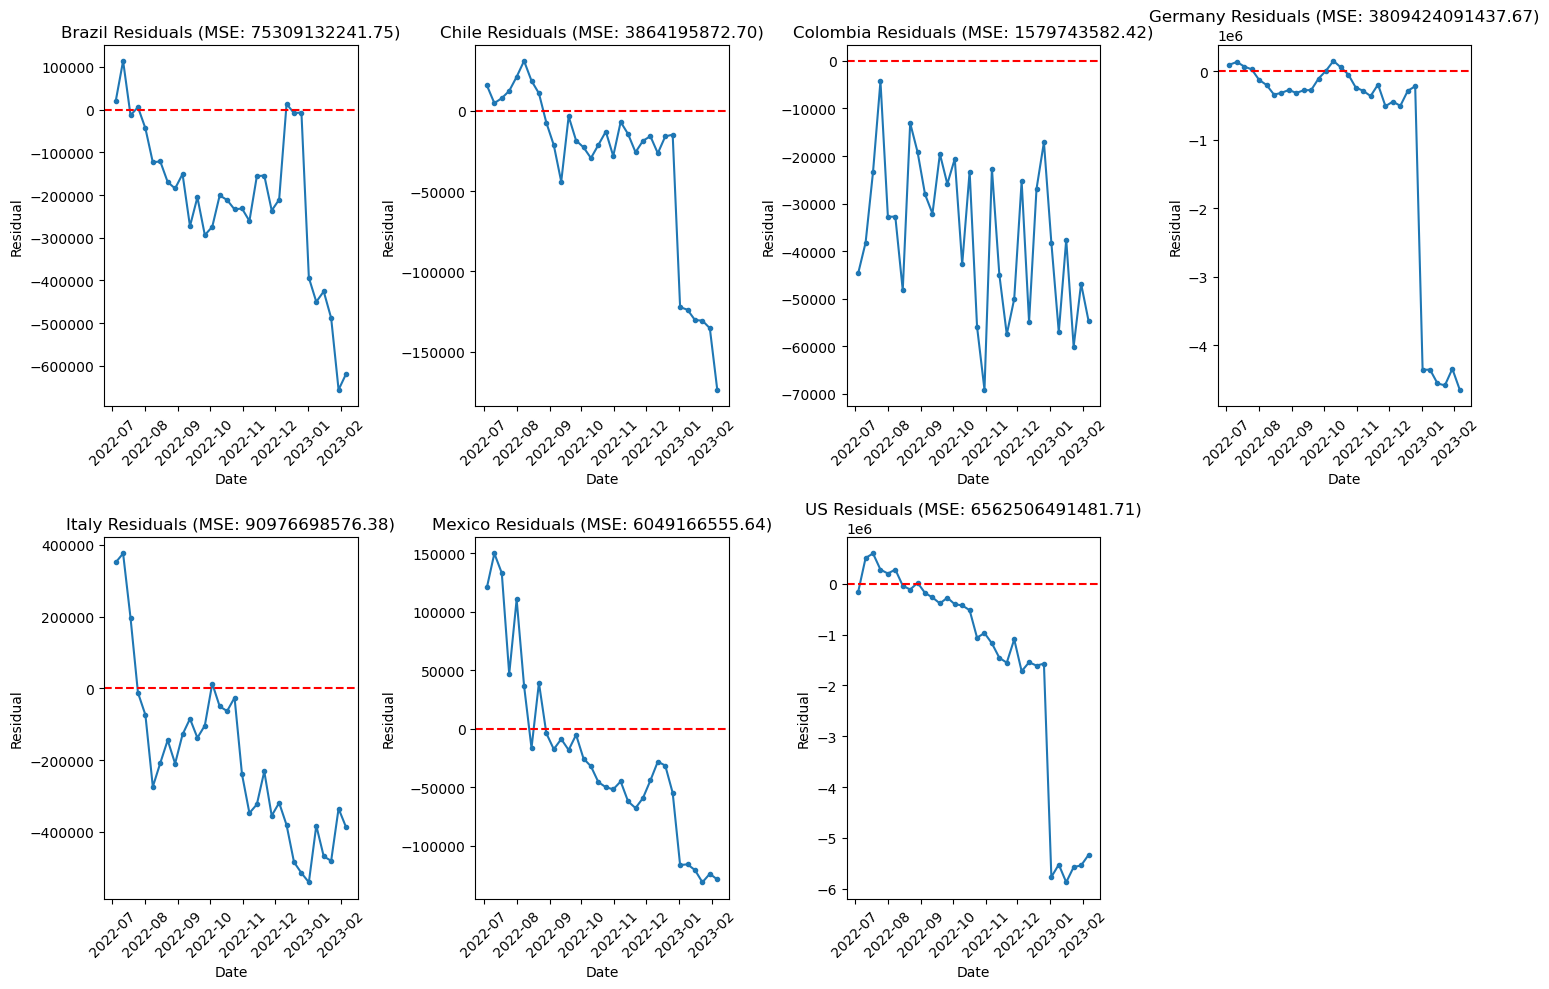

In [15]:
from sklearn.linear_model import Ridge
plot_country_residuals_scaled(df_og, Ridge(alpha=1.0))

## Elastic Net

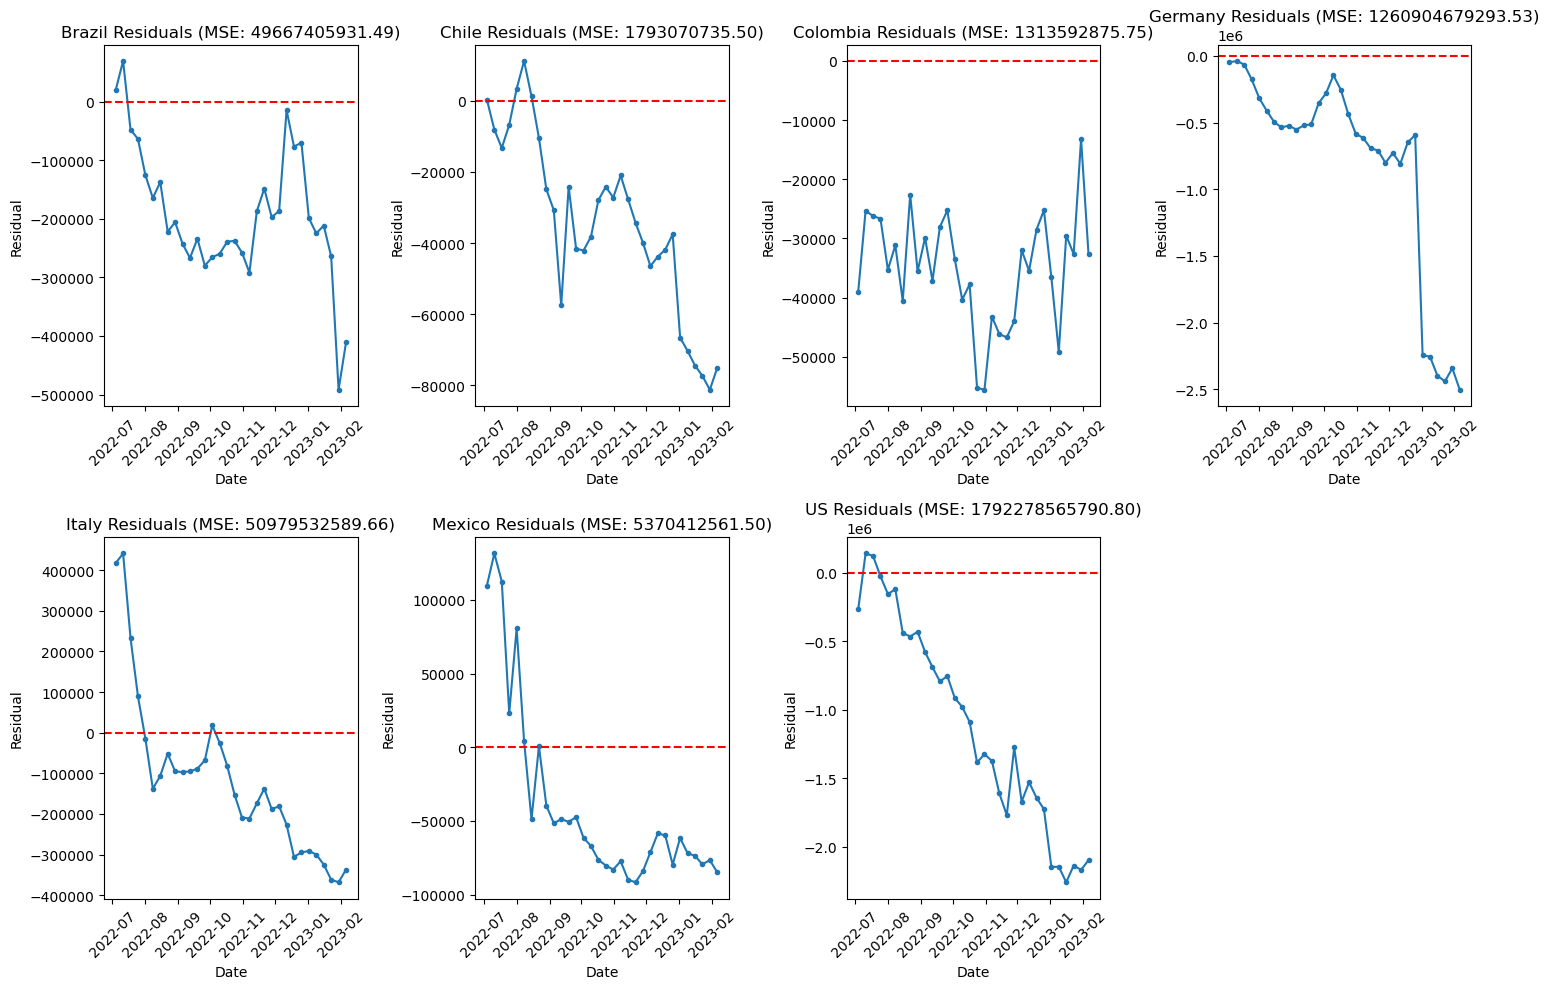

In [16]:
from sklearn.linear_model import ElasticNet
plot_country_residuals_scaled(df_og, ElasticNet(alpha=1.0, l1_ratio=0.5))

## Random Forest

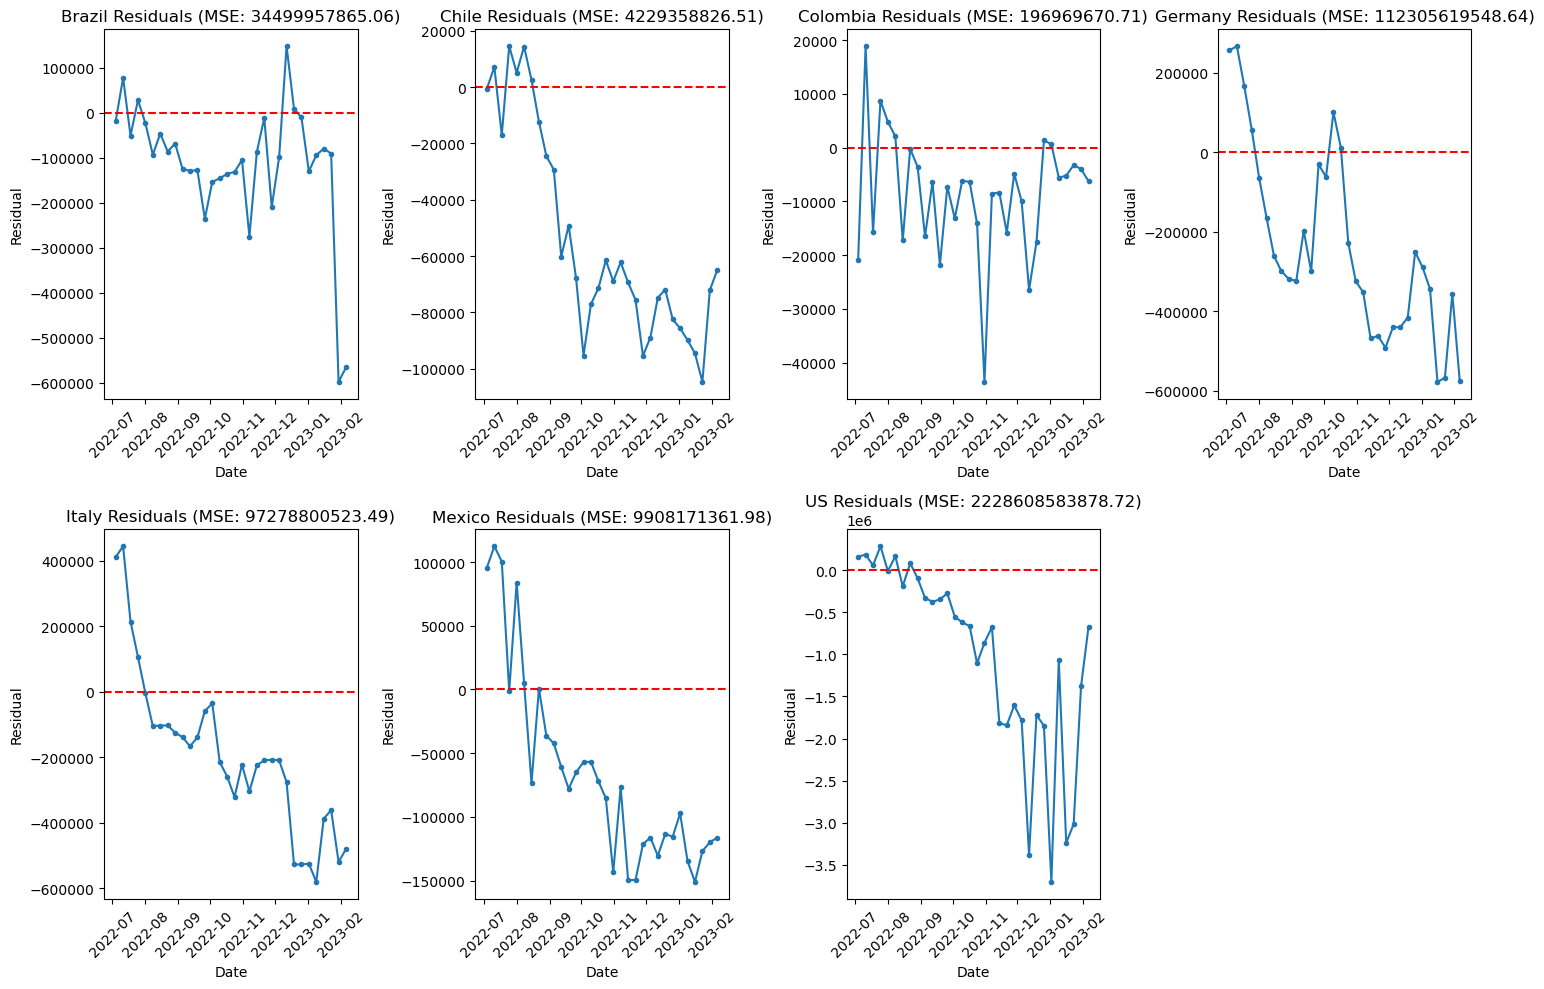

In [17]:
from sklearn.ensemble import RandomForestRegressor
plot_country_residuals_scaled(df_og, RandomForestRegressor())

## Gradient Boosting

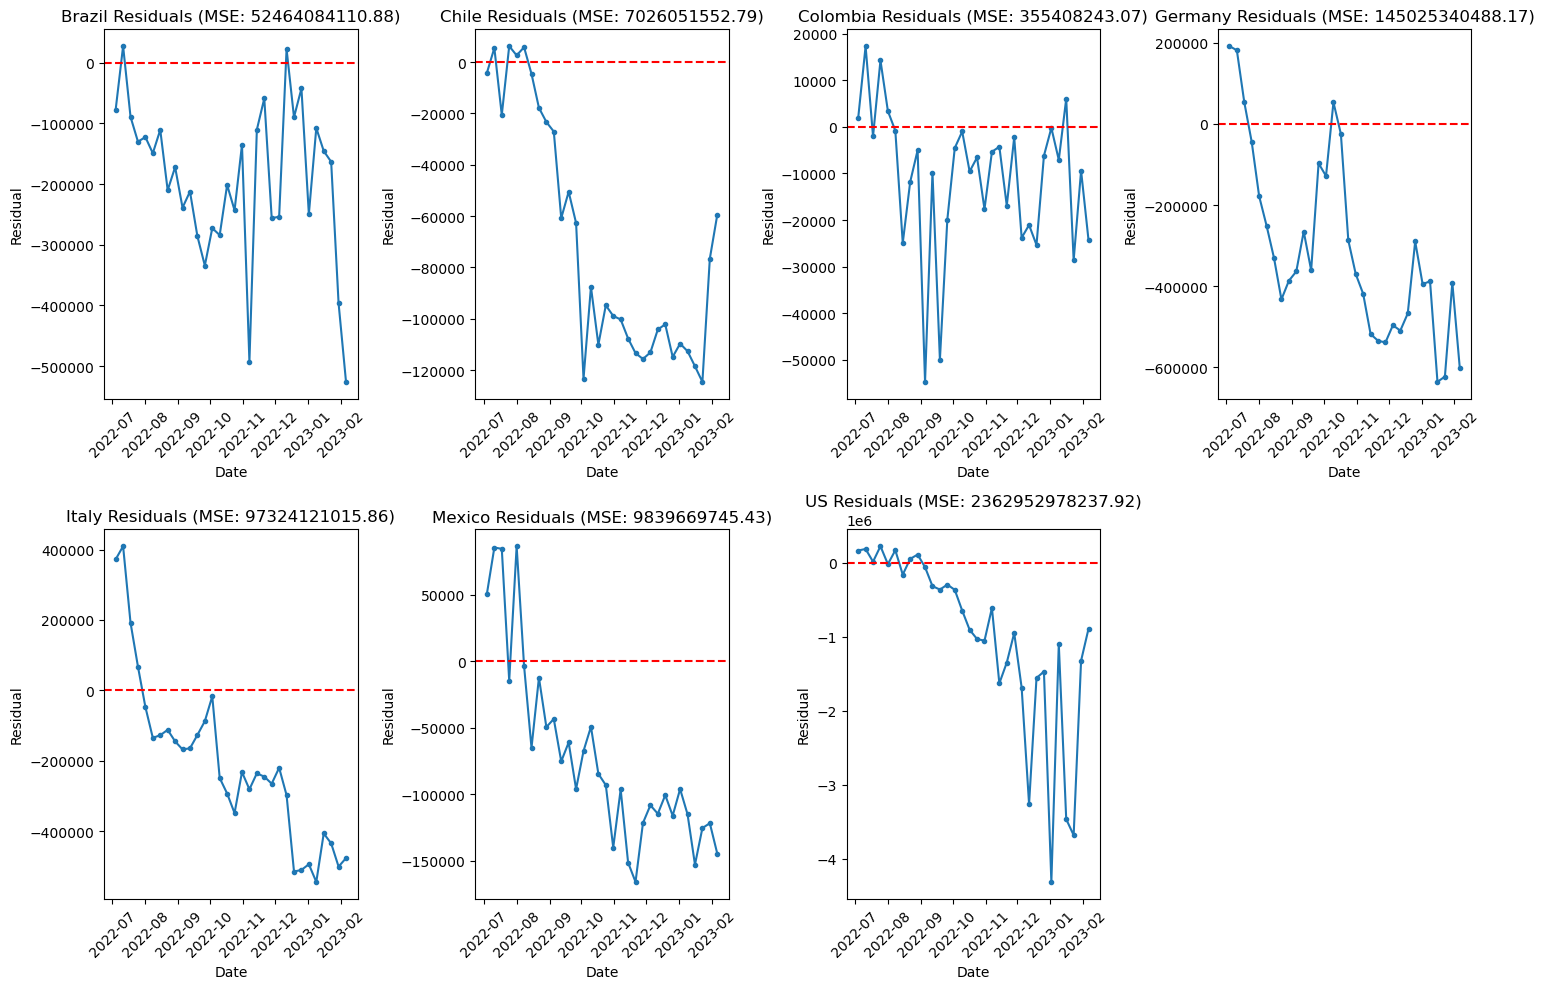

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
plot_country_residuals_scaled(df_og, GradientBoostingRegressor())

## Metrics

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd

def evaluate_models_per_country(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        y = df_country['new_cases']
        X = df_country.drop(columns=['cases','new_cases', 'cases_t_4','cases_t_1', 'date', 'country'])

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)

In [20]:
# Example usage:
results_df = evaluate_models_per_country(df_og)
print(results_df)

     country             model          RMSE          R2
0     Brazil  LinearRegression  3.417464e+05   -9.624966
1     Brazil             Lasso  3.417169e+05   -9.623133
2     Brazil             Ridge  2.744251e+05   -5.851211
3     Brazil        ElasticNet  2.228619e+05   -3.518468
4     Brazil      RandomForest  1.625746e+05   -1.404501
5     Brazil  GradientBoosting  2.495174e+05   -4.663977
6      Chile  LinearRegression  6.405795e+04  -13.212001
7      Chile             Lasso  6.404644e+04  -13.206893
8      Chile             Ridge  6.216266e+04  -12.383456
9      Chile        ElasticNet  4.234467e+04   -5.210214
10     Chile      RandomForest  6.408997e+04  -13.226213
11     Chile  GradientBoosting  6.244222e+04  -12.504103
12  Colombia  LinearRegression  5.148868e+04  -50.864612
13  Colombia             Lasso  5.139949e+04  -50.685093
14  Colombia             Ridge  3.974599e+04  -29.905395
15  Colombia        ElasticNet  3.624352e+04  -24.698542
16  Colombia      RandomForest 

In [21]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model = results_df.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model = mean_rmse_per_model.idxmin()
lowest_mean_rmse = mean_rmse_per_model.min()

print(f"The model with the lowest mean RMSE is {best_model} with a mean RMSE of {lowest_mean_rmse:.2f}")

The model with the lowest mean RMSE is RandomForest with a mean RMSE of 340844.81


In [22]:
mean_rmse_per_model

model
ElasticNet          437454.260180
GradientBoosting    388569.512158
Lasso               866573.590791
LinearRegression    866609.732383
RandomForest        340844.806034
Ridge               752749.589212
Name: RMSE, dtype: float64

In [23]:
results_df[results_df['model'] == 'RandomForest']

,country,model,RMSE,R2
4,Brazil,RandomForest,1.625746e+05,-1.404501
10,Chile,RandomForest,6.408997e+04,-13.226213
16,Colombia,RandomForest,1.368034e+04,-2.661349
22,Germany,RandomForest,3.485846e+05,-2.451527
28,Italy,RandomForest,2.769126e+05,-2.069874
34,Mexico,RandomForest,9.513215e+04,-2.214840
40,US,RandomForest,1.424939e+06,-44.949482


## Cases t+4
4 weeks later

In [24]:
def evaluate_models_per_country_4(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        y = df_country['cases_t_4']
        X = df_country.drop(columns=['cases_t_4', 'cases_t_1','date', 'country'])

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)


In [25]:

results_df_4 = evaluate_models_per_country_4(df_og)
print(results_df_4)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.091e+12, tolerance: 5.959e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e+10, tolerance: 2.460e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

     country             model          RMSE          R2
0     Brazil  LinearRegression  3.953137e+05  -27.397983
1     Brazil             Lasso  3.943709e+05  -27.262690
2     Brazil             Ridge  2.711366e+05  -12.359183
3     Brazil        ElasticNet  1.903150e+05   -5.581877
4     Brazil      RandomForest  2.039899e+05   -6.561729
5     Brazil  GradientBoosting  2.801205e+05  -13.259147
6      Chile  LinearRegression  6.206434e+04  -13.271346
7      Chile             Lasso  6.292631e+04  -13.670509
8      Chile             Ridge  5.850049e+04  -11.679431
9      Chile        ElasticNet  3.730940e+04   -4.157238
10     Chile      RandomForest  8.184128e+04  -23.815643
11     Chile  GradientBoosting  9.792417e+04  -34.527160
12  Colombia  LinearRegression  7.873524e+04 -651.213861
13  Colombia             Lasso  8.878841e+04 -828.400424
14  Colombia             Ridge  5.280288e+04 -292.337033
15  Colombia        ElasticNet  1.807929e+04  -33.388581
16  Colombia      RandomForest 

In [26]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model_4 = results_df_4.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model_4 = mean_rmse_per_model_4.idxmin()
lowest_mean_rmse_4 = mean_rmse_per_model_4.min()

print(f"The model with the lowest mean RMSE is {best_model_4} with a mean RMSE of {lowest_mean_rmse_4:.2f}")

The model with the lowest mean RMSE is ElasticNet with a mean RMSE of 334987.33


In [27]:
mean_rmse_per_model_4

model
ElasticNet          334987.332774
GradientBoosting    386174.784313
Lasso               675191.345587
LinearRegression    648911.217447
RandomForest        381235.554596
Ridge               573218.170349
Name: RMSE, dtype: float64

In [28]:
results_df_4[results_df_4['model'] == 'ElasticNet']

,country,model,RMSE,R2
3,Brazil,ElasticNet,190315.013443,-5.581877
9,Chile,ElasticNet,37309.398426,-4.157238
15,Colombia,ElasticNet,18079.285338,-33.388581
21,Germany,ElasticNet,828844.308157,-28.528355
27,Italy,ElasticNet,322598.825779,-14.322436
33,Mexico,ElasticNet,73079.476064,-6.156318
39,US,ElasticNet,874685.022209,-30.901598


# Explanatory variables

We now implement a version which compares all the countries in a single model so it can consider differences in variables such as population density

In [29]:
def evaluate_models(df, target_variable):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    if target_variable == 'new_cases':
        X = df.drop(columns=[target_variable, 'date', 'cases', 'cases_lag1','cases_t_4', 'cases_t_1'])
    elif target_variable == 'cases_t_4':
        X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])

    y = df[target_variable]

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Identify dummy (binary) columns
    dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
    numeric_cols = [col for col in X.columns if col not in dummy_cols]

    # Scale only numeric columns
    scaler = StandardScaler()
    X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

    # Reassemble scaled numeric columns and dummy columns
    X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

    all_results = []

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results_dict = {
            'Model': model_name,
            'RMSE': rmse,
            'R2': r2
        }

        all_results.append(results_dict)

    results_df = pd.DataFrame(all_results)
    return results_df


In [30]:
# call the function
results_df = evaluate_models(df, target_variable='new_cases')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+13, tolerance: 4.113e+09
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE          R2
0  LinearRegression  7.990379e+06 -117.615553
1             Lasso  8.262698e+05   -0.268384
2             Ridge  7.713660e+05   -0.105422
3        ElasticNet  7.571381e+05   -0.065019
4      RandomForest  7.095449e+05    0.064666
5  GradientBoosting  7.735298e+05   -0.111632


In [31]:
# call the function
results_df = evaluate_models(df, target_variable='cases_t_4')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.875e+12, tolerance: 4.099e+09
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE         R2
0  LinearRegression  4.557001e+06 -37.800854
1             Lasso  7.157684e+05   0.042744
2             Ridge  6.946166e+05   0.098484
3        ElasticNet  6.660074e+05   0.171217
4      RandomForest  6.851656e+05   0.122850
5  GradientBoosting  6.987480e+05   0.087729


# Check Explainability

### Lasso

In [33]:
from sklearn.linear_model import LassoCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


Best alpha (lambda): 13679.282007238095
RMSE: 745392.2914
R2: -0.0322
Selected features by Lasso: [np.str_('co'), np.str_('population'), np.str_('date_numeric')]


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6434726352.6328125, tolerance: 3877264293.1091986
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14356736915.941406, tolerance: 3877264293.1091986
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25685986864.3125, tolerance: 3877264293.1091986
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages

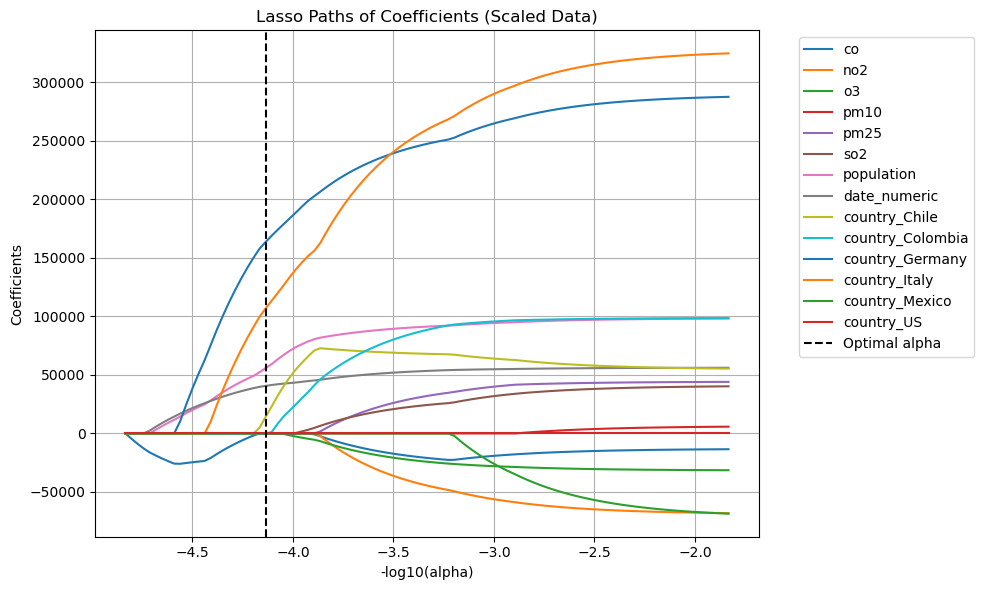

In [34]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [35]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


Best alpha (lambda): 6458.363184869262
RMSE: 671730.8359
R2: 0.1569
Selected features by Lasso: [np.str_('new_cases'), np.str_('co'), np.str_('no2'), np.str_('o3'), np.str_('pm10'), np.str_('so2'), np.str_('population'), np.str_('date_numeric')]


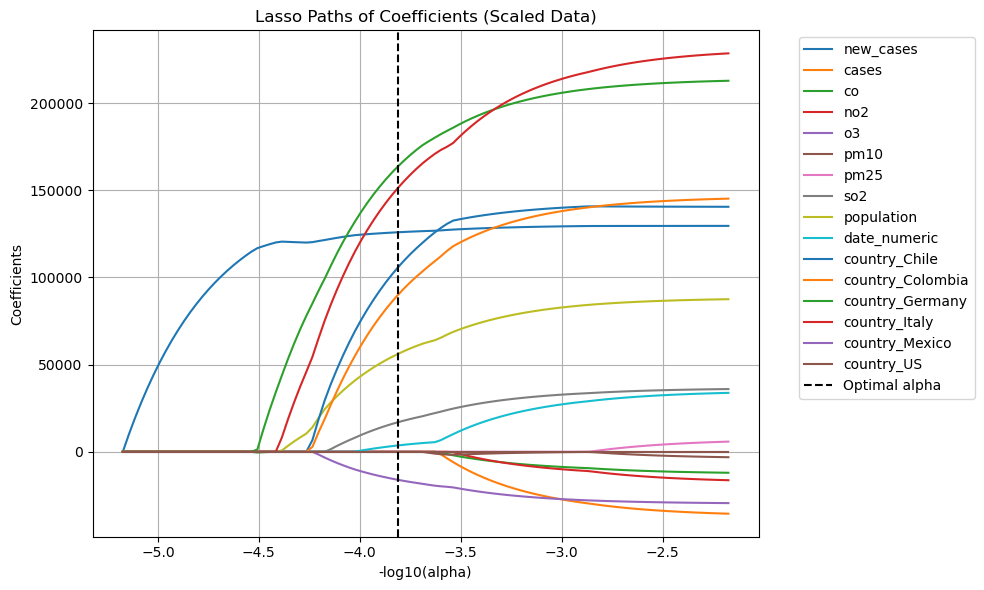

In [36]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

### Elastic Net

In [37]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda) and l1_ratio
elasticnet_cv = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .3,  .5, .7, .9, .95, .99, 1])

elasticnet_cv.fit(X_train_scaled, y_train)

# Best parameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(f"Best alpha (lambda): {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Predict on test set
y_pred = elasticnet_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[elasticnet_cv.coef_ != 0]
print(f"Selected features by ElasticNet: {list(selected_features)}")


Best alpha (lambda): 6458.363184869262
Best l1_ratio: 1.0
RMSE: 671730.8359
R2: 0.1569
Selected features by ElasticNet: [np.str_('new_cases'), np.str_('co'), np.str_('no2'), np.str_('o3'), np.str_('pm10'), np.str_('so2'), np.str_('population'), np.str_('date_numeric')]


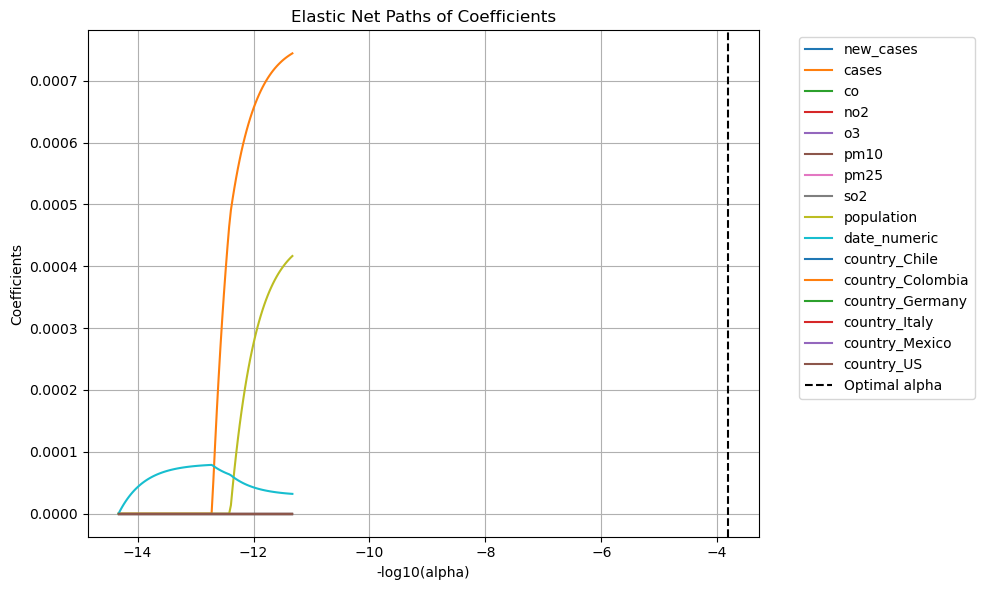

In [38]:
from sklearn.linear_model import enet_path
# Compute coefficient paths using enet_path
alphas_enet, coefs_enet, _ = enet_path(X_train, y_train, l1_ratio=best_l1_ratio)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_enet)

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_enet, X.columns):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Elastic Net Paths of Coefficients')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [38]:
print(best_alpha)


5265.089552364166


## Random Forest

In [39]:
from sklearn.model_selection import GridSearchCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 704970.8575
R2: 0.0767


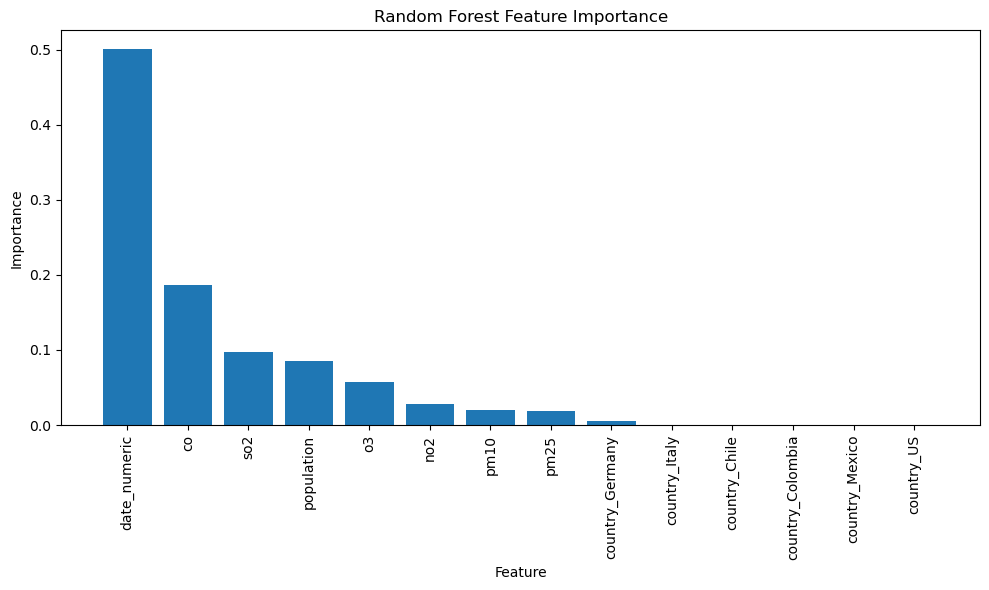

In [40]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [41]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
RMSE: 681264.0537
R2: 0.1328


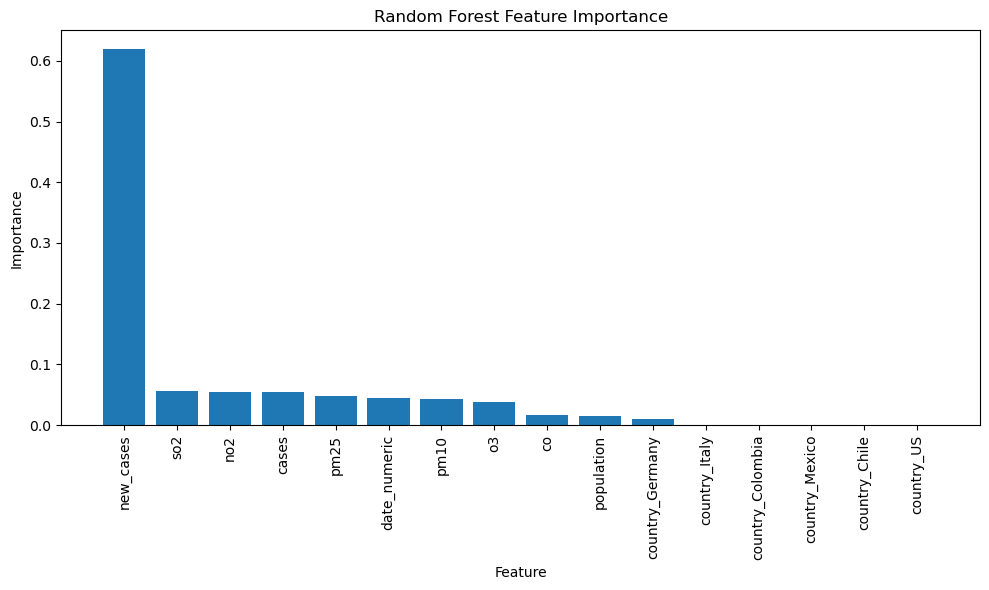

In [42]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [43]:
# Define your target and features
target_variable = 'cases_t_1'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 524088.6510
R2: 0.4889


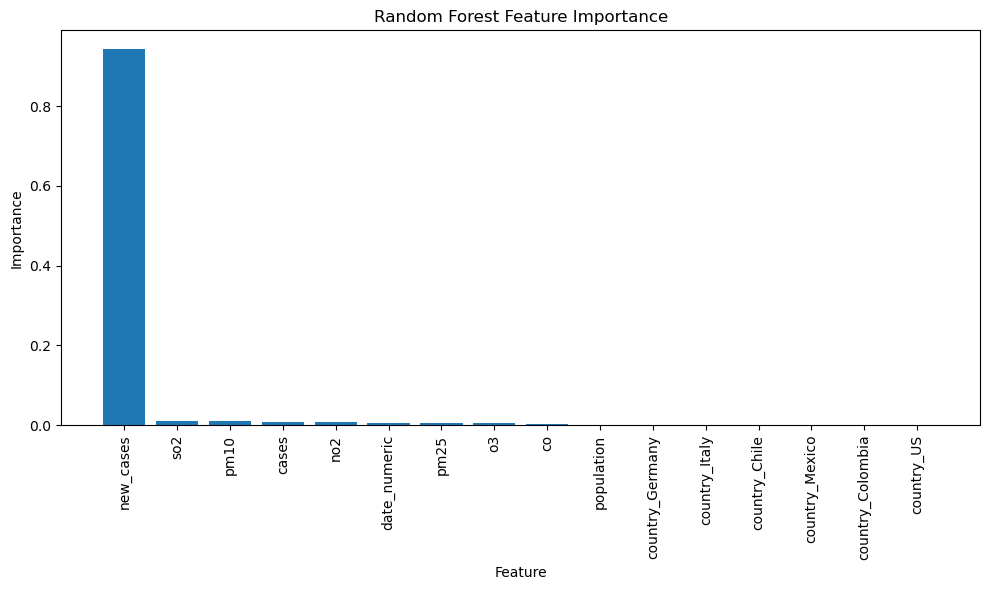

In [44]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

## Gradient Boosting

In [47]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 754702.3198
R2: -0.0642


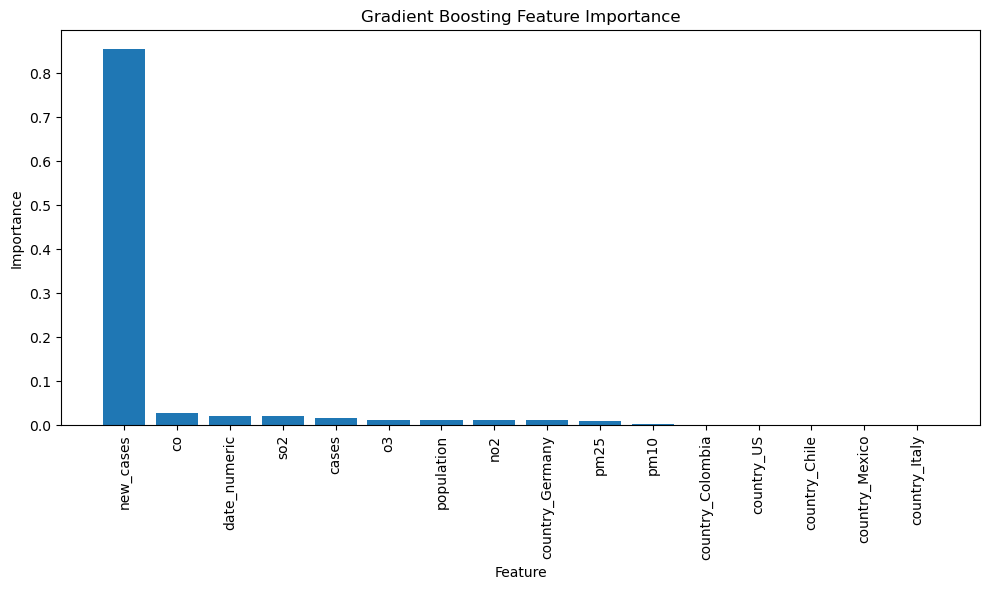

In [48]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [50]:
# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cumulative_cases', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = grid_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
RMSE: 41371.8658
R2: -0.0614


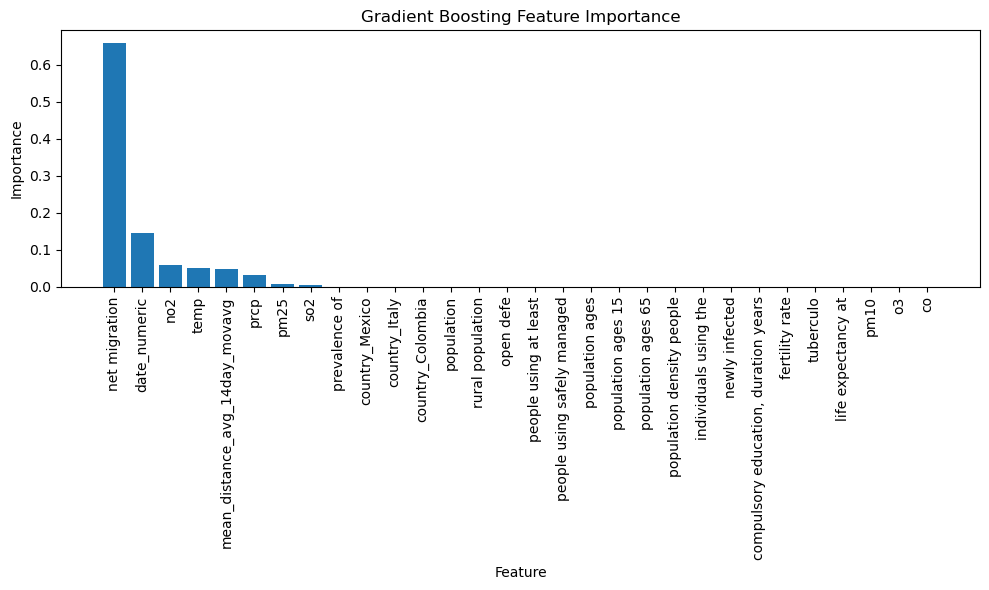

In [51]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = numeric_cols + dummy_cols

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [53]:
!pip install shap

   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------------------------- ------ 2.4/2.8 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.6 MB 9.0 MB/s eta 0:00:02
   -------------- ------------------------- 4.5/12.6 MB 9.9 MB/s eta 0:00:01
   -------------------- ------------------- 6.6/12.6 MB 10.1 MB/s eta 0:00:01
   --------------------------- ------------ 8.7/12.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.6 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------  12.3/12.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 9.5 MB/s eta 0:00:00
   ----------

  You can safely remove it manually.
  You can safely remove it manually.


In [55]:
import shap

# Initialize the SHAP explainer with the best estimator from the grid search
explainer = shap.Explainer(grid_search.best_estimator_, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.